# Bootstrap with imputation

This notebook explains how to use `bootstrap_with_imputation`. `bootstrap_with_imputation` performs causal discovery with multiple imputations on data with missing values.

Hereinafter, NaN or nan represents missing values.

## Import and settings

In [1]:
import numpy as np

import lingam
from lingam.utils import make_dot
from lingam.tools import bootstrap_with_imputation

import matplotlib.pyplot as plt

print([np.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.24.4', '1.8.3']


## Test data

Test data is generated according to the following adjacency matrix.

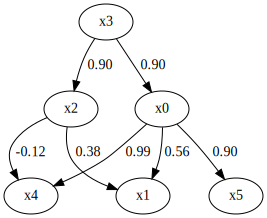

In [2]:
m = np.array([
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.565,  0.000,  0.377,  0.000,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.000,  0.000,  0.000],
    [ 0.991,  0.000, -0.124,  0.000,  0.000,  0.000],
    [ 0.895,  0.000,  0.000,  0.000,  0.000,  0.000]
])

make_dot(m)

The variance of all variables in this data is approximately 1.0 and the mean is approximately 0.0, the variance of error terms excluding an exogenous variable is approximately 0.2.

In [3]:
sample_size = 1000

error_vars = [0.2, 0.2, 0.2, 1.0, 0.2, 0.2]
params = [0.5 * np.sqrt(12 * v) for v in error_vars]

generate_error = lambda p: np.random.uniform(-p, p, size=sample_size)
e = np.array([generate_error(p) for p in params])

X = np.linalg.pinv(np.eye(len(m)) - m) @ e
X = X.T

X.shape

(1000, 6)

In [4]:
X.mean(axis=0)

array([-0.057, -0.03 , -0.042, -0.056, -0.069, -0.061])

In [5]:
X.var(axis=0)

array([0.968, 0.989, 1.021, 0.982, 0.979, 0.973])

In [6]:
e.T.var(axis=0)

array([0.203, 0.215, 0.197, 0.982, 0.191, 0.202])

Some data for x5 will be replaced by NaN using the MCAR method.

In [7]:
X_mcar = X.copy()

prop_missing = [0, 0, 0, 0, 0, 0.1]

for i, prop in enumerate(prop_missing):
    mask = np.random.uniform(0, 1, size=len(X_mcar))
    X_mcar[mask < prop, i] = np.nan

The proportaion of missing is the following:

In [8]:
np.isnan(X_mcar).sum(axis=0) / sample_size

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.098])

## Causal discovery with missing data

`bootstrap_with_imputation` discovers causality in given data with NaNs.

In the following settings, `bootstrap_with_imputation` creates 30 bootstrap samples and repeat the imputation 5 times for each bootstrap sample and performs causal discovery assuming a common causal structure on the 5 imputed data.

In [9]:
n_sampling = 30
n_repeats = 5
causal_orders, adj_matrices_list, resampled_indices, imputation_results = bootstrap_with_imputation(X_mcar, n_sampling, n_repeats)

`causal_orders` stores the causal order of the 30 bootstrap samples.

In [10]:
causal_orders.shape

(30, 6)

`adj_matrices_list` is the list of adjacency matrices estimated from the results of 5 repeated imputations for each of the 30 bootstrap samples.

In [11]:
adj_matrices_list.shape

(30, 5, 6, 6)

`resampled_indices` contains lists of the original indices of the 30 bootstrap samples.

In [12]:
resampled_indices.shape

(30, 1000)

`imputation_results` stores the result of imputations.

In [13]:
imputation_results.shape

(30, 5, 1000, 6)

## Checking results

### Comparing obtained results with results for data with no missing

#### Histogram

The results for data with no missing data are as follows:

In [14]:
model = lingam.DirectLiNGAM()
bs_result = model.bootstrap(X, n_sampling)

The adjacency matirces is stored in `adjacency_matrices_`.

In [15]:
bs_result.adjacency_matrices_.shape

(30, 6, 6)

The distributions of the elements of the estimated adjacency matrix of the two bootstrap results are compared as follows:

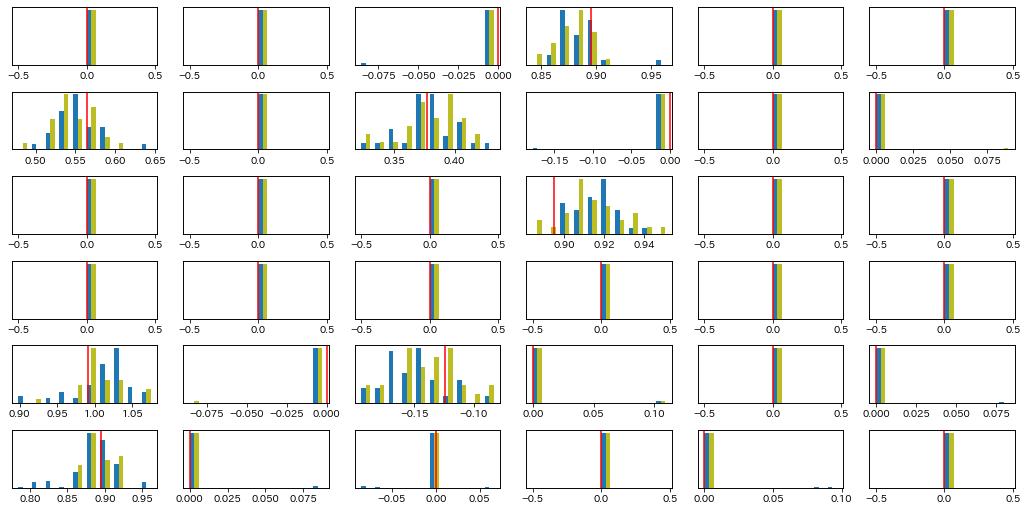

In [16]:
n_features = X.shape[1]

fig, axes = plt.subplots(n_features, n_features, figsize=(n_features * 2.4, n_features * 1.2))

for i in range(n_features):
    for j in range(n_features):
        result_missing = adj_matrices_list[:, :, i, j].flatten()
        result_no_missing = bs_result.adjacency_matrices_[:, i, j].flatten()
        
        xrange = (
            min(*result_missing, *result_no_missing),
            max(*result_missing, *result_no_missing)
        )
        
        hist, edges = np.histogram(result_missing, range=xrange)
        hist2, edges2 = np.histogram(result_no_missing, range=xrange)
        
        width = (edges[1] - edges[0]) / 3
        
        ax = axes[i, j]
        ax.bar(edges[:-1], hist, width=width, align="edge", color="tab:blue")
        ax.set_yticks([])
        
        ax = axes[i, j].twinx()
        ax.bar(edges2[:-1] + width, hist2, width=width, align="edge", color="tab:olive")
        ax.set_yticks([])
        
        ax.axvline(m[i, j], color="red")

plt.tight_layout()
plt.show()

Red vertical lines indicate true values. The [i, j] of this scatter matrix indicates the distribution of the [i, j] of the adjacency matrix. Blue histograms are results with missing data, orange histograms are results with no missing data. 

#### Median value of each element of the matrix

Median values of each element of the adjacency matrix estimated on the data with missing values are as follows:

In [17]:
np.median(adj_matrices_list, axis=(0, 1))

array([[ 0.   ,  0.   ,  0.   ,  0.882,  0.   ,  0.   ],
       [ 0.555,  0.   ,  0.381,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.918,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 1.025,  0.   , -0.147,  0.   ,  0.   ,  0.   ],
       [ 0.892,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

The average value of each element of the adjacency matrix estimated on the data with no missing values is as follows:

In [18]:
np.median(bs_result.adjacency_matrices_, axis=0)

array([[ 0.   ,  0.   ,  0.   ,  0.882,  0.   ,  0.   ],
       [ 0.546,  0.   ,  0.383,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.912,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 1.002,  0.   , -0.136,  0.   ,  0.   ,  0.   ],
       [ 0.89 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

Comparing each result with the adjacency matrix used in the data generation, it is clear that they are all able to estimate the presence of true edges.

In [19]:
m

array([[ 0.   ,  0.   ,  0.   ,  0.895,  0.   ,  0.   ],
       [ 0.565,  0.   ,  0.377,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.895,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.991,  0.   , -0.124,  0.   ,  0.   ,  0.   ],
       [ 0.895,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

## Getting bootstrap samples and imputed bootstrap samples

To get bootstrap samples, do the following:

In [20]:
bootstrap_samples = np.array([X_mcar[indices] for indices in resampled_indices])
bootstrap_samples.shape

(30, 1000, 6)

`bootstrap_samples` contains NaNs. For example, the number of NaNs that the first bootstrap sample has is as follows:

In [21]:
np.isnan(bootstrap_samples[0]).sum(axis=0)

array([ 0,  0,  0,  0,  0, 85])

`imputation_results` stores the result of the imputation. When X_mcar[i, j] is NaN, the complementary values are stored in the imputation_results[i, j], and when X_mcar[i, j] is non-NaN, NaN is stored in the imputation_results[i, j].

The first 8 rows of the first imputation result for the first bootstrap sample is as follows:

In [22]:
imputation_results[0, 0, :8]

array([[  nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan, 0.188],
       [  nan,   nan,   nan,   nan,   nan,   nan]])

The first 8 rows of each of the first bootstrap_sample is as follows:

In [23]:
bootstrap_samples[0, :8]

array([[-0.193, -0.072,  1.018,  0.328, -0.863, -0.622],
       [-1.972, -1.887, -1.687, -1.489, -1.216, -1.622],
       [-0.444, -1.18 , -0.49 ,  0.269, -0.483, -0.011],
       [ 0.531,  0.996,  1.201,  0.968,  1.035,  0.708],
       [-2.202, -1.915, -0.988, -1.704, -1.42 , -1.531],
       [ 1.6  ,  1.756,  0.591,  1.127,  1.494,  0.743],
       [ 0.441, -0.17 , -0.933, -0.244,  1.117,    nan],
       [ 0.746,  1.629,  1.329,  0.976,  0.302,  0.756]])

`bootstrap_samples` is the data before the imputation is performed, so the missing values are still NaN. 

To obtain the imputed bootstrap_samples, do the following:

In [24]:
imputed_bootstrap_samples = []

for i in range(n_sampling):
    imputeds = []
    for j in range(n_repeats):
        pos = ~np.isnan(imputation_results[i, j])
        
        imputed = bootstrap_samples[i].copy()
        imputed[pos] = imputation_results[i, j, pos]
        
        imputeds.append(imputed)
    imputed_bootstrap_samples.append(imputeds)
imputed_bootstrap_samples = np.array(imputed_bootstrap_samples)

It is confirmed that NaN was imputed.

In [25]:
imputed_bootstrap_samples[0, 0, :8]

array([[-0.193, -0.072,  1.018,  0.328, -0.863, -0.622],
       [-1.972, -1.887, -1.687, -1.489, -1.216, -1.622],
       [-0.444, -1.18 , -0.49 ,  0.269, -0.483, -0.011],
       [ 0.531,  0.996,  1.201,  0.968,  1.035,  0.708],
       [-2.202, -1.915, -0.988, -1.704, -1.42 , -1.531],
       [ 1.6  ,  1.756,  0.591,  1.127,  1.494,  0.743],
       [ 0.441, -0.17 , -0.933, -0.244,  1.117,  0.188],
       [ 0.746,  1.629,  1.329,  0.976,  0.302,  0.756]])